<a href="https://colab.research.google.com/github/Geetika-L/Econ_472/blob/dev/Econ_472_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

In [6]:
!pip install scikit-optimize --user
!pip install scikit-learn==1.2.1

In [7]:
data_v1 = pd.read_csv('fred_data_trans_v1.csv')

In [8]:
percent_missing = list(data_v1.isna().sum()/(data_v1.shape[0]))
missing_value_df = pd.DataFrame({'column_name': data_v1.columns,
                                 'percent_missing': percent_missing})

In [9]:
## Prportion of columns that have high NAs
missing_value_df_01 = missing_value_df.loc[missing_value_df['percent_missing']>0.1]
## Higher than 0.1 (ACOGNO:New Orders for Consumer Goods, ANDENOx: New Orders for Nondefense Capital Goods,  TWEXAFEGSMTHx: Trade weighted us dollar index)

In [10]:
## Remove high proportion of NAs
col_to_rem_NA = missing_value_df_01['column_name'].tolist()
data_v1.drop(col_to_rem_NA, axis =1, inplace= True)



In [11]:
## Remove CPI columns except CPI: All items
cpis_except_all_items = ['CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5']
data_v1.drop(cpis_except_all_items, axis =1, inplace= True)


In [12]:
## Remove the date column
data_v1.drop('date', axis =1, inplace= True)


In [13]:
## Creating lag and AR variables
def series_to_supervised(data, n_in=1):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """

 n_vars = 1 if type(data.values) is list else data.shape[1]
 colnames = list(data.columns)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
   cols.append(data.shift(i))
   names += [j+"_{0}".format(i) for j in colnames]
 cols.append(data['CPIAUCSL'])
 names += ['CPIAUCSL_0']
 
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 return agg
#  # drop rows with NaN values
#  if dropnan:
#  agg.dropna(inplace=True)
#  return agg


In [14]:
data_lagged = series_to_supervised(data_v1,3)

In [15]:
data_lagged_sorted = data_lagged.reindex(sorted(data_lagged.columns), axis=1)

In [13]:
data_lagged_sorted.to_csv('data_lagged_v1.csv')

In [16]:
## Remove first 3 observations (missing lags), and last 12 observations to keep as test set
test_length = 12
startpoint = 3
endpoint = len(data_lagged)
x = endpoint- test_length
data_lagged_train = data_lagged.loc[startpoint:x - 1, :]
data_lagged_test = data_lagged.loc[x:, :]
data_lagged_test_x = data_lagged_test.loc[:, data_lagged_test.columns != 'CPIAUCSL_0']
data_lagged_test_y = data_lagged_test['CPIAUCSL_0']
data_lagged_train_x = data_lagged_train.loc[:, data_lagged_train.columns != 'CPIAUCSL_0']
data_lagged_train_y = data_lagged_train['CPIAUCSL_0']

In [17]:
## Getting mean of training dataset to impute
import numpy as np
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values = np.nan, strategy = 'mean').set_output(transform="pandas")
imp.fit(data_lagged_train_x)

SimpleImputer()

In [18]:
##Impute training data x

data_lagged_train_x_imp = imp.transform(data_lagged_train_x)

##Impute testing data x
data_lagged_test_x_imp = imp.transform(data_lagged_test_x)

In [19]:
data_lagged_train_x_imp.head(5)

,RPI_3,W875RX1_3,DPCERA3M086SBEA_3,CMRMTSPLx_3,RETAILx_3,INDPRO_3,IPFPNSS_3,IPFINAL_3,IPCONGD_3,IPDCONGD_3,...,DNDGRG3M086SBEA_1,DSERRG3M086SBEA_1,CES0600000008_1,CES2000000008_1,CES3000000008_1,UMCSENTx_1,DTCOLNVHFNM_1,DTCTHFNM_1,INVEST_1,VIXCLSx_1
3,0.003194,0.004638,0.002788,0.016956,0.026606,0.025914,0.024097,0.029021,0.031237,0.103831,...,0.001786,-0.001113,-0.000020,0.030131,-0.004684,0.0,0.003472,0.000951,0.003490,19.294122
4,0.001143,0.000917,0.004335,0.014371,0.003696,-0.008936,-0.005683,-0.003441,-0.011454,-0.013854,...,0.004439,0.001450,-0.008949,-0.068074,0.000000,0.0,0.008678,0.005452,0.024136,19.294122
5,0.001909,0.000916,0.014041,-0.028026,-0.001102,-0.009020,-0.003429,-0.001145,0.001151,-0.019966,...,-0.006723,0.000591,0.008949,0.041620,0.000000,-6.7,-0.004827,-0.002067,0.003798,19.294122
6,0.003419,0.003614,0.015355,0.009826,0.025903,-0.007958,0.002289,0.001145,0.006879,-0.001186,...,0.000222,-0.000686,-0.004474,-0.011429,0.000000,0.0,0.005126,0.007420,-0.009981,19.294122
7,0.002401,0.002443,-0.020343,-0.031531,-0.015047,-0.001144,0.005690,0.006866,0.005699,0.009453,...,0.001828,0.000504,0.004454,0.007547,0.000000,0.0,-0.010926,-0.003291,0.032176,19.294122


In [20]:
data_lagged_train_x_imp.shape

(741, 345)

In [ ]:
#Setting up BayesSearchCV


In [20]:
# from sklearn.ensemble import RandomForestRegressor
# from skopt import BayesSearchCV,space

# param_dist = {
#     "max_depth": space.Integer(3, 6),
#     "max_features": space.Integer(40, 120),
#     "min_samples_split": space.Integer(2,5), # from 2 to 10
#     "min_samples_leaf": space.Integer(5,7), # from 1 to 10
#    }


In [21]:
# search_v0 = BayesSearchCV(RandomForestRegressor(n_estimators=150, random_state=153),
#                        param_dist,random_state=153,scoring='neg_mean_squared_error', n_iter=30,verbose=2)

In [22]:
# search_v0.fit(data_lagged_train_x_imp,data_lagged_train_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=5, max_features=95, min_samples_leaf=5, min_samples_split=2; total time=   2.6s
[CV] END max_depth=5, max_features=95, min_samples_leaf=5, min_samples_split=2; total time=   2.5s
[CV] END max_depth=5, max_features=95, min_samples_leaf=5, min_samples_split=2; total time=   3.1s
[CV] END max_depth=5, max_features=95, min_samples_leaf=5, min_samples_split=2; total time=   2.6s
[CV] END max_depth=5, max_features=95, min_samples_leaf=5, min_samples_split=2; total time=   2.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=4, max_features=89, min_samples_leaf=7, min_samples_split=3; total time=   2.0s
[CV] END max_depth=4, max_features=89, min_samples_leaf=7, min_samples_split=3; total time=   2.0s
[CV] END max_depth=4, max_features=89, min_samples_leaf=7, min_samples_split=3; total time=   2.2s
[CV] END max_depth=4, max_features=89, min_samples_leaf=7, min_samples_split=3; total time

/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=6, max_features=120, min_samples_leaf=7, min_samples_split=2; total time=   3.3s
[CV] END max_depth=6, max_features=120, min_samples_leaf=7, min_samples_split=2; total time=   3.3s
[CV] END max_depth=6, max_features=120, min_samples_leaf=7, min_samples_split=2; total time=   3.2s
[CV] END max_depth=6, max_features=120, min_samples_leaf=7, min_samples_split=2; total time=   3.8s
[CV] END max_depth=6, max_features=120, min_samples_leaf=7, min_samples_split=2; total time=   3.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=6, max_features=120, min_samples_leaf=5, min_samples_split=5; total time=   3.5s
[CV] END max_depth=6, max_features=120, min_samples_leaf=5, min_samples_split=5; total time=   4.0s
[CV] END max_depth=6, max_features=120, min_samples_leaf=5, min_samples_split=5; total time=   3.5s
[CV] END max_depth=6, max_features=120, min_samples_leaf=5, min_samples_split=5; t

BayesSearchCV(estimator=RandomForestRegressor(n_estimators=150,
                                              random_state=153),
              n_iter=30, random_state=153, scoring='neg_mean_squared_error',
              search_spaces={'max_depth': Integer(low=3, high=6, prior='uniform', transform='normalize'),
                             'max_features': Integer(low=40, high=120, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=5, high=7, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=5, prior='uniform', transform='normalize')},
              verbose=2)

In [27]:
# search_v0.best_params_

OrderedDict([('max_depth', 6),
             ('max_features', 120),
             ('min_samples_leaf', 5),
             ('min_samples_split', 2)])

In [28]:
# # Trying another search based on previous best params
# param_dist_1 = {
#     "max_depth": space.Integer(5, 10),
#     "max_features": space.Integer(115, 160),
#     "min_samples_split": space.Integer(2,4), 
#     "min_samples_leaf": space.Integer(4,7)
#    }

In [30]:
# search_v1 = BayesSearchCV(RandomForestRegressor(n_estimators=200, random_state=153),
#                        param_dist_1,random_state=153,scoring='neg_mean_squared_error', n_iter=40,verbose=2, cv=5)

# search_v1.fit(data_lagged_train_x_imp,data_lagged_train_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=9, max_features=146, min_samples_leaf=4, min_samples_split=2; total time=   8.8s
[CV] END max_depth=9, max_features=146, min_samples_leaf=4, min_samples_split=2; total time=   7.3s
[CV] END max_depth=9, max_features=146, min_samples_leaf=4, min_samples_split=2; total time=   8.0s
[CV] END max_depth=9, max_features=146, min_samples_leaf=4, min_samples_split=2; total time=   7.5s
[CV] END max_depth=9, max_features=146, min_samples_leaf=4, min_samples_split=2; total time=   8.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=7, max_features=142, min_samples_leaf=6, min_samples_split=3; total time=   6.5s
[CV] END max_depth=7, max_features=142, min_samples_leaf=6, min_samples_split=3; total time=   6.0s
[CV] END max_depth=7, max_features=142, min_samples_leaf=6, min_samples_split=3; total time=   6.4s
[CV] END max_depth=7, max_features=142, min_samples_leaf=6, min_samples_split=3; t

/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, max_features=159, min_samples_leaf=4, min_samples_split=2; total time=   8.3s
[CV] END max_depth=10, max_features=159, min_samples_leaf=4, min_samples_split=2; total time=   8.7s
[CV] END max_depth=10, max_features=159, min_samples_leaf=4, min_samples_split=2; total time=   8.8s
[CV] END max_depth=10, max_features=159, min_samples_leaf=4, min_samples_split=2; total time=   7.9s
[CV] END max_depth=10, max_features=159, min_samples_leaf=4, min_samples_split=2; total time=   8.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=7, max_features=148, min_samples_leaf=7, min_samples_split=3; total time=   6.4s
[CV] END max_depth=7, max_features=148, min_samples_leaf=7, min_samples_split=3; total time=   6.0s
[CV] END max_depth=7, max_features=148, min_samples_leaf=7, min_samples_split=3; total time=   6.2s
[CV] END max_depth=7, max_features=148, min_samples_leaf=7, min_samples_split

BayesSearchCV(cv=5,
              estimator=RandomForestRegressor(n_estimators=200,
                                              random_state=153),
              n_iter=40, random_state=153, scoring='neg_mean_squared_error',
              search_spaces={'max_depth': Integer(low=5, high=10, prior='uniform', transform='normalize'),
                             'max_features': Integer(low=115, high=160, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=4, high=7, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=4, prior='uniform', transform='normalize')},
              verbose=2)

In [31]:
# abs(search_v0.best_score_)

6.372271773632763e-06

In [32]:
# abs(search_v1.best_score_)

6.257980306326264e-06

In [ ]:
#search.best_estimator_

RandomForestRegressor(max_depth=5, max_features=135,
                      max_samples=0.9928109876715059, min_samples_leaf=5,
                      n_estimators=150, random_state=153)

In [ ]:
#search1.best_estimator_

RandomForestRegressor(max_depth=10, max_features=149,
                      max_samples=0.9986390128212231, min_samples_leaf=4,
                      min_samples_split=4, n_estimators=200, random_state=153)

In [33]:
# Pickle and dump random forests
# from joblib import dump,load
# dump(search_v0.best_estimator_, 'search_v0.joblib')
# dump(search_v1.best_estimator_,'search_v1.joblib')

['search_v1.joblib']

In [ ]:
##Upload rf models to test

In [21]:
## Model v0 and v1 - from first search
from joblib import load
model_v0 = load('search_v0.joblib')
model_v1 = load('search_v1.joblib')

In [45]:
## Extracting the date column for analysis
start_date = pd.to_datetime('01-1960', format='%m-%Y')
end_date = pd.to_datetime('12-2022', format='%m-%Y')
date_list = list(map(lambda x: x.strftime('%m-%Y'), pd.date_range(start_date, end_date, freq="MS")))
date_train = date_list[startpoint:x]
date_test = date_list[x:]

#### Using proper lags data for forecasting

In [23]:
##Preparing a script to get 12 month ahead forecast

def forecast_ahead_12(model_fc, test_data_og):
  test_data = test_data_og.copy(deep = True)
  test_data.reset_index(drop=True, inplace = True)
  CPI_lags_cols = ['CPIAUCSL_1','CPIAUCSL_2','CPIAUCSL_3']
  y_pred_test = []
  for i in range(12):
    y = model_fc.predict(test_data.iloc[[i]])
    y_pred_test.append(y)
    prev_CPI_2 = test_data.loc[i]['CPIAUCSL_2']
    prev_CPI_1 = test_data.loc[i]['CPIAUCSL_1']
    if i < 11:
        test_data.loc[i+1]['CPIAUCSL_1'] = y
        test_data.loc[i+1]['CPIAUCSL_2'] = prev_CPI_1
        test_data.loc[i+1]['CPIAUCSL_3'] = prev_CPI_2
  ##flatten y_pred_test
  y_pred_test = np.ravel(y_pred_test)

  return y_pred_test, test_data

In [24]:
## Creating a scoring function
def mse_horizons(true, predicted):
  mse_vals=[]
  if len(true) == len(predicted):
    array_abs_diff = (true-predicted)**2
    for i in range(len(true)):
      mse_vals.append(np.mean(array_abs_diff[:i+1]))
  return mse_vals

In [25]:
## Creating the predictions and updated test dataset for both models v0 and v1
y_pred_test_model_v0, test_data_model_v0 = forecast_ahead_12(model_v0,data_lagged_test_x_imp)
y_pred_test_model_v1, test_data_model_v1 = forecast_ahead_12(model_v1,data_lagged_test_x_imp)

In [26]:
## MSE for model v0 and MSE for model v1
mse_model_v0 = mse_horizons(data_lagged_test_y,y_pred_test_model_v0)
mse_model_v1 = mse_horizons(data_lagged_test_y,y_pred_test_model_v1)

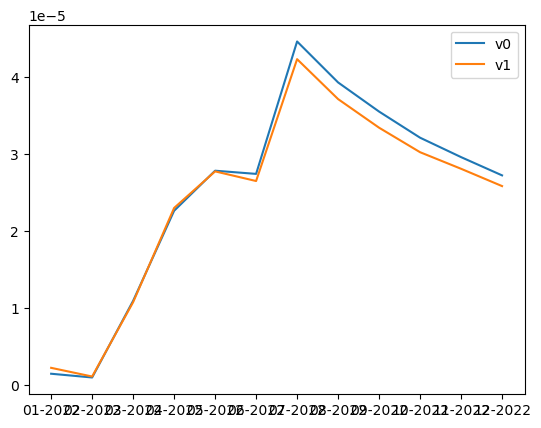

In [48]:
import matplotlib.pyplot as plt
plt.plot(date_test,mse_model_v0, label= 'v0')
plt.plot(date_test,mse_model_v1, label = 'v1')
plt.xticks(date_test)
plt.legend()
plt.show()

#### Using the same data in the first row for everything in non CPI lags (i.e using december 2021 data for Jan- Dec 2022 preds)

In [28]:
def forecast_ahead_12_fixed_lag_vals(model_fc, test_data_og):
  test_data = test_data_og.copy(deep = True)
  test_data.reset_index(drop=True, inplace = True)
  CPI_lags_cols = ['CPIAUCSL_1','CPIAUCSL_2','CPIAUCSL_3']
  ## Split data in CPI and non CPI
  df_non_CPI = test_data.drop(columns=CPI_lags_cols)
  df_non_CPI_fixed_lags_vals = pd.concat(([df_non_CPI.iloc[[0]]])*12,ignore_index=True)
  df_CPI = test_data[CPI_lags_cols]
  test_data = pd.concat([df_CPI.reset_index(drop=True), df_non_CPI_fixed_lags_vals.reset_index(drop=True)], axis= 1)
  test_data = test_data[test_data_og.columns]

  y_pred_test = []
  for i in range(12):
    y = model_fc.predict(test_data.iloc[[i]])
    y_pred_test.append(y)
    prev_CPI_2 = test_data.loc[i]['CPIAUCSL_2']
    prev_CPI_1 = test_data.loc[i]['CPIAUCSL_1']
    if i < 11:
        test_data.loc[i+1]['CPIAUCSL_1'] = y
        test_data.loc[i+1]['CPIAUCSL_2'] = prev_CPI_1
        test_data.loc[i+1]['CPIAUCSL_3'] = prev_CPI_2
  ##flatten y_pred_test
  y_pred_test = np.ravel(y_pred_test)

  return y_pred_test, test_data

In [29]:
## Creating the predictions and updated test dataset for both models v0 and v1
y_pred_test_model_v0_flv, test_data_model_v0_flv = forecast_ahead_12_fixed_lag_vals(model_v0,data_lagged_test_x_imp)
y_pred_test_model_v1_flv, test_data_model_v1_flv = forecast_ahead_12_fixed_lag_vals(model_v1,data_lagged_test_x_imp)

In [30]:
mse_model_v0_flv = mse_horizons(data_lagged_test_y,y_pred_test_model_v0_flv)
mse_model_v1_flv = mse_horizons(data_lagged_test_y,y_pred_test_model_v1_flv)

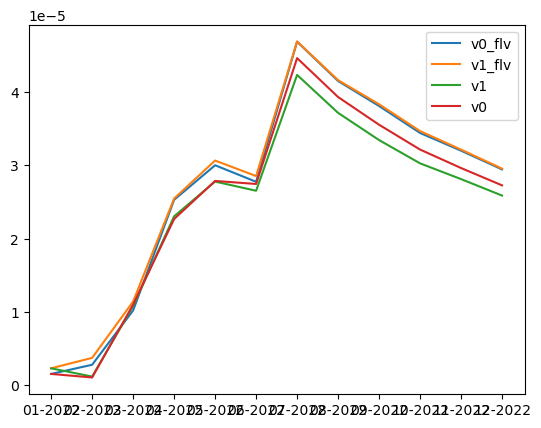

In [49]:
import matplotlib.pyplot as plt
plt.plot(date_test,mse_model_v0_flv, label= 'v0_flv')
plt.plot(date_test,mse_model_v1_flv, label = 'v1_flv')
plt.plot(date_test,mse_model_v1, label = 'v1')
plt.plot(date_test,mse_model_v0, label = 'v0')
plt.xticks(date_test)
plt.legend()
plt.show()

##Using model V1 as from now on for rest of analysis